In [1]:
import pandas as pd

In [2]:
hotdog = pd.read_csv('Q2_citi_vendors.csv')
hotdog.head()

,game,day,section,vendor,hot_dogs_sold
0,1,2,1,6,145
1,1,2,2,10,121
2,1,2,3,21,56
3,1,2,4,8,123
4,1,2,5,4,100


In [3]:
hotdog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1620 entries, 0 to 1619
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   game           1620 non-null   int64
 1   day            1620 non-null   int64
 2   section        1620 non-null   int64
 3   vendor         1620 non-null   int64
 4   hot_dogs_sold  1620 non-null   int64
dtypes: int64(5)
memory usage: 63.4 KB


EXPLAIN AVERAGES AND ALL THAT 

In [4]:
def add_avg_row(df,col):
    avg_col = df.groupby(col).mean()['hot_dogs_sold']
    df[f'{col}_avg'] = hotdog[col].apply(lambda x:avg_col[x])
    return df

In [5]:
cols = hotdog.columns[0:4].to_numpy()

for col in cols:
    hotdog = add_avg_row(hotdog,col)

In [6]:
hotdog

,game,day,section,vendor,hot_dogs_sold,game_avg,day_avg,section_avg,vendor_avg
0,1,2,1,6,145,134.70,125.379167,151.740741,156.906667
1,1,2,2,10,121,134.70,125.379167,127.222222,131.506849
2,1,2,3,21,56,134.70,125.379167,127.037037,159.750000
3,1,2,4,8,123,134.70,125.379167,120.148148,121.728571
4,1,2,5,4,100,134.70,125.379167,130.185185,108.779221
...,...,...,...,...,...,...,...,...,...
1615,81,5,16,16,112,128.65,130.650000,132.728395,145.675676
1616,81,5,17,11,92,128.65,130.650000,137.098765,129.554054
1617,81,5,18,5,138,128.65,130.650000,125.641975,142.178082
1618,81,5,19,23,67,128.65,130.650000,134.098765,120.130435


In [7]:
X = hotdog.iloc[:,-5:].copy() # all rows, last 4 columns

In [8]:
X

,hot_dogs_sold,game_avg,day_avg,section_avg,vendor_avg
0,145,134.70,125.379167,151.740741,156.906667
1,121,134.70,125.379167,127.222222,131.506849
2,56,134.70,125.379167,127.037037,159.750000
3,123,134.70,125.379167,120.148148,121.728571
4,100,134.70,125.379167,130.185185,108.779221
...,...,...,...,...,...
1615,112,128.65,130.650000,132.728395,145.675676
1616,92,128.65,130.650000,137.098765,129.554054
1617,138,128.65,130.650000,125.641975,142.178082
1618,67,128.65,130.650000,134.098765,120.130435


In [9]:
y = hotdog['hot_dogs_sold']
X.drop('hot_dogs_sold',axis=1,inplace = True)

In [10]:
y

0       145
1       121
2        56
3       123
4       100
       ... 
1615    112
1616     92
1617    138
1618     67
1619      0
Name: hot_dogs_sold, Length: 1620, dtype: int64

In [11]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X,y)
lin.coef_,lin.intercept_

(array([ 9.89101131e-01, -6.17512967e-04,  9.66479770e-01,  9.66764915e-01]),
 -254.43326842859733)

In [12]:
import statsmodels.api as sm

X_withconstant = sm.add_constant(X) # add constant manually for sm

reg = sm.OLS(y, X_withconstant) # y first for sm

reg_results = reg.fit()

reg_results.summary()

/Users/Daniel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          hot_dogs_sold   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     84.76
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           2.08e-65
Time:                        23:11:36   Log-Likelihood:                -8974.3
No. Observations:                1620   AIC:                         1.796e+04
Df Residuals:                    1615   BIC:                         1.799e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -254.4333     24.606    -10.340      0.000    -302.696    -206.171
game_avg        0.9891      0.125      7.886      0.000       0.743       1.235
day_avg        -0.0006      0.158     -0.004      0.997      -0.310       0.309
section_avg     0.9665      0.132      7.317      0.000       0.707       1.226
vendor_avg      0.9668      0.092     10.477      0.000       0.786       1.148
==============================================================================
Omnibus:                        5.552   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.540
Skew:                           0.143   Prob(JB):                       0.0627
Kurtosis:                       3.006   Cond. No.                     4.26e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

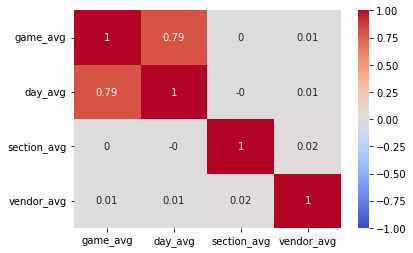

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = X.corr()
plt.figure()
sns.heatmap(corr.round(2), vmax = 1, vmin = -1, center = 0, annot =True, cmap = 'coolwarm')
plt.show()

In [14]:
X.drop('day_avg',axis = 1,inplace = True)

In [15]:
import statsmodels.api as sm

X_withconstant = sm.add_constant(X) # add constant manually for sm

reg = sm.OLS(y, X_withconstant) # y first for sm

reg_results = reg.fit()

reg_results.summary()

/Users/Daniel/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          hot_dogs_sold   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     113.1
Date:                Sun, 15 Jan 2023   Prob (F-statistic):           1.80e-66
Time:                        23:11:36   Log-Likelihood:                -8974.3
No. Observations:                1620   AIC:                         1.796e+04
Df Residuals:                    1616   BIC:                         1.798e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -254.4635     23.352    -10.897      0.000    -300.268    -208.659
game_avg        0.9887      0.076     12.966      0.000       0.839       1.138
section_avg     0.9665      0.132      7.320      0.000       0.707       1.225
vendor_avg      0.9668      0.092     10.481      0.000       0.786       1.148
==============================================================================
Omnibus:                        5.549   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.062   Jarque-Bera (JB):                5.537
Skew:                           0.143   Prob(JB):                       0.0628
Kurtosis:                       3.006   Cond. No.                     3.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
import random
random.seed(0) # set randomness for code reproduction
from tqdm import tqdm

old_coefs = reg_results.params[1:].values
old_intercept = reg_results.params[0]
errors = reg_results.bse
preds = pd.DataFrame(columns=['batterID','at-bat','pitcherID','result_prediction'])

pbar = tqdm(range(1,101)) # tqdm progress bar
for i in pbar: # for one batter...
    batter_skill = df.loc[df['batterID'] == i,'batter_skill'].iloc[0]
    for j in range(1,301): #one at bat
        rand = random.randint(101,200) # pitcher ID
        pitcher_skill = df.loc[df['pitcherID'] == rand,'pitcher_skill'].iloc[0]
        skills = np.array([batter_skill,pitcher_skill])
        pbar.set_description(f'Simming for Batter {i}, At-Bat {j} against Pitcher {rand}')
        

        coefs = old_coefs.copy() # reset original values from model
        intercept = old_intercept
        
        assert (coefs == old_coefs).all()
        assert intercept== old_intercept

        # adding +- error based on normal distribution with mean zero and std dev of error values         
        np.random.seed(999999)
        randnorm = np.random.normal(loc = 0, scale = errors[0],size = 1)
        intercept  += randnorm
        
        randnorm = np.random.normal(loc = 0, scale = errors[1],size = 1)
        coefs[0]  += randnorm
                        
        randnorm = np.random.normal(loc = 0, scale = errors[2],size = 1)
        coefs[1]  += randnorm
        
        pred = float(np.dot(coefs,skills) + intercept) # dot product of betas and x's + intercepts all with std error sim
        dic = pd.DataFrame(data = [{"batterID":i,'at-bat':j,"pitcherID":rand,"result_prediction":pred}])
        preds = pd.concat([preds,dic],ignore_index= True)

  0%|                                                   | 0/100 [00:00<?, ?it/s]


NameError: name 'df' is not defined

# MONTE CARLO